# Make Money With Machine Learning (Week 2) - Finance
# Stock Prediction

![alt text](https://miro.medium.com/max/3840/1*opzxrBna63YDbd8_pM5trw.png)


In [1]:
#Execute seperately first
pip install talib-binary

     |████████████████████████████████| 2.4MB 4.8MB/s 


# 1. Preparing data and a linear model

In this Section, we will see how machine learning can be used in finance. We will also explore some stock data, and prepare it for machine learning algorithms. Finally, we will fit our first machine learning model -- a linear model, in order to predict future price changes of stocks.

In [0]:
#pip install talib-binary
#import packages
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import talib

In [0]:
#to get the stock data
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 1, 1)

df = web.DataReader("AAPL", 'yahoo', start, end)
google = web.DataReader("GOOGL", 'yahoo', start, end)

# Explore the data with some EDA
First, let's explore the data. Any time we begin a machine learning (ML) project, we need to first do some exploratory data analysis (EDA) to familiarize ourselves with the data. This includes things like:

-raw data plots
-histograms
-and more...


I typically begin with raw data plots and histograms. This allows us to understand our data's distributions. If it's a normal distribution, we can use things like parametric statistics.

In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,151.550003,146.589996,148.149994,146.830002,37169200.0,145.090836
2018-12-26,157.229996,146.720001,148.300003,157.169998,58582500.0,155.308350
2018-12-27,156.770004,150.070007,155.839996,156.149994,53117100.0,154.300446
2018-12-28,158.520004,154.550003,157.500000,156.229996,42291400.0,154.379486
2018-12-31,159.360001,156.479996,158.529999,157.740005,35003500.0,155.871613


In [5]:
google.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,1012.119995,977.659973,984.320007,984.669983,1818000.0,984.669983
2018-12-26,1048.449951,992.650024,997.989990,1047.849976,2315900.0,1047.849976
2018-12-27,1053.339966,1007.000000,1026.199951,1052.900024,2299800.0,1052.900024
2018-12-28,1064.229980,1042.000000,1059.500000,1046.680054,1719900.0,1046.680054
2018-12-31,1062.989990,1033.040039,1057.829956,1044.959961,1655500.0,1044.959961


In [6]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000
mean,132.355248,130.079289,131.230753,131.241425,4.293548e+07,125.196498
std,37.771772,37.064776,37.435126,37.414122,2.358373e+07,38.716523
min,71.647141,70.507141,70.739998,71.397141,1.147590e+07,64.441742
25%,104.374998,102.440002,102.900000,103.037502,2.660625e+07,96.386761
50%,119.889999,118.215000,118.940002,119.180000,3.698370e+07,112.138847
75%,159.990002,156.707500,158.522499,157.830002,5.234740e+07,153.961807
max,233.470001,229.779999,230.779999,232.070007,2.663808e+08,228.523819


In [7]:
google.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000
mean,809.258642,795.009542,802.572477,802.265164,2.094093e+06,802.265164
std,217.150533,212.581804,214.805075,214.871210,1.161235e+06,214.871210
min,500.279999,490.910004,499.239990,497.059998,5.206000e+05,497.059998
25%,591.458603,583.282516,587.690018,587.234055,1.400900e+06,587.234055
50%,778.095001,764.244995,770.364990,770.300018,1.746350e+06,770.300018
75%,997.582489,982.744980,991.740005,991.759995,2.352500e+06,991.759995
max,1291.439941,1263.000000,1289.119995,1285.500000,1.285810e+07,1285.500000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2014-01-02 to 2018-12-31
Data columns (total 6 columns):
High         1258 non-null float64
Low          1258 non-null float64
Open         1258 non-null float64
Close        1258 non-null float64
Volume       1258 non-null float64
Adj Close    1258 non-null float64
dtypes: float64(6)
memory usage: 68.8 KB


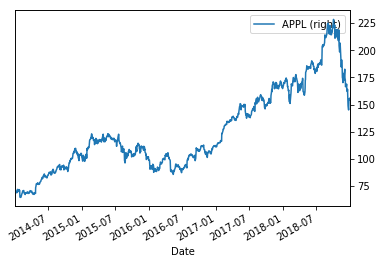

In [9]:
df['Adj Close'].plot(label='APPL', legend=True, secondary_y=True)
plt.show()

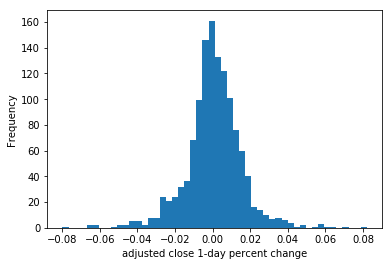

In [10]:
df['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

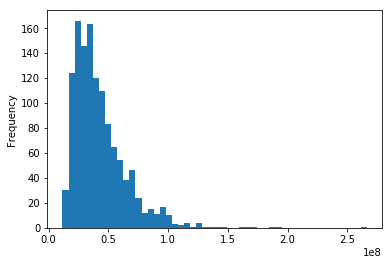

In [11]:
vol = df['Volume']
vol.plot.hist(bins=50)
plt.show()

# Correlations
Correlations are nice to check out before building machine learning models, because we can see which features correlate to the target most strongly. Pearson's correlation coefficient is often used, which only detects linear relationships. It's commonly assumed our data is normally distributed, which we can "eyeball" from histograms. Highly correlated variables have a Pearson correlation coefficient near 1 (positively correlated) or -1 (negatively correlated). A value near 0 means the two variables are not linearly correlated.

If we use the same time periods for previous price changes and future price changes, we can see if the stock price is mean-reverting (bounces around) or trend-following (goes up if it has been going up recently).

In [12]:
corr = df.corr()
print(corr)

               High       Low      Open     Close    Volume  Adj Close
High       1.000000  0.999308  0.999575  0.999513 -0.414317   0.998794
Low        0.999308  1.000000  0.999438  0.999559 -0.432849   0.998800
Open       0.999575  0.999438  1.000000  0.999022 -0.421627   0.998291
Close      0.999513  0.999559  0.999022  1.000000 -0.425046   0.999231
Volume    -0.414317 -0.432849 -0.421627 -0.425046  1.000000  -0.431600
Adj Close  0.998794  0.998800  0.998291  0.999231 -0.431600   1.000000


                      10d_close_pct  10d_close_future_pct
10d_close_pct              1.000000              0.017988
10d_close_future_pct       0.017988              1.000000


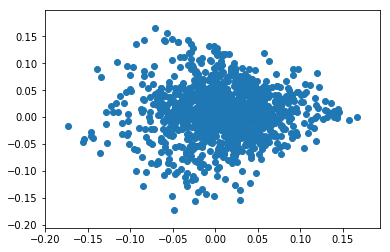

In [13]:
# Create 10-day % changes of Adj_Close for the current day, and 10 days in the future
df['10d_future_close'] = df['Adj Close'].shift(-10)
df['10d_close_future_pct'] = df['10d_future_close'].pct_change(10)
df['10d_close_pct'] = df['Adj Close'].pct_change(10)

# Calculate the correlation matrix between the 10d close pecentage changes (current and future)
corr = df[['10d_close_pct', '10d_close_future_pct']].corr()
print(corr)

# Scatter the current 10-day percent change vs the future 10-day percent change
plt.scatter(df['10d_close_pct'], df['10d_close_future_pct'])
plt.show()

RSI equation

RSI = 100 - (100 / 1 + RS)

Whereas, 

RS = Average gain over n periods / Average loss over n periods



**Create moving average and RSI features**
We want to add historical data to our machine learning models to make better predictions, but adding lots of historical time steps is tricky. Instead, we can condense information from previous points into a single timestep with indicators.

A moving average is one of the simplest indicators - it's the average of previous data points. This is the function talib.SMA() from the TAlib library.

Another common technical indicator is the relative strength index (RSI). This is defined by:

RSI=100−(100 / 1+RS)


---


RS= average gain over n periods / average loss over n periods


---


The n periods is set in talib.RSI() as the timeperiod argument.

A common period for RSI is 14, so we'll use that as one setting in our calculations.

In [14]:
feature_names = ['10d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    df['ma' + str(n)] = talib.SMA(df['Adj Close'].values,
                              timeperiod=n) /df['Adj Close']
    # Create the RSI indicator
    df['rsi' + str(n)] = talib.RSI(df['Adj Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['10d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


**Create features and targets**

We almost have features and targets that are machine-learning ready -- we have features from current price changes (5d_close_pct) and indicators (moving averages and RSI), and we created targets of future price changes (5d_close_future_pct). Now we need to break these up into separate numpy arrays so we can feed them into machine learning algorithms.

Our indicators also cause us to have missing values at the beginning of the DataFrame due to the calculations. We could backfill this data, fill it with a single value, or drop the rows. Dropping the rows is a good choice, so our machine learning algorithms aren't confused by any sort of backfilled or 0-filled data. Pandas has a .dropna() function which we will use to drop any rows with missing values.

In [15]:
# Drop all na values
df = df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = df[feature_names]
targets = df['10d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['10d_close_future_pct'] + feature_names
feat_targ_df = df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                      10d_close_future_pct  10d_close_pct  ...     ma200    rsi200
10d_close_future_pct              1.000000       0.073235  ... -0.021165 -0.011691
10d_close_pct                     0.073235       1.000000  ... -0.412417  0.341887
ma14                             -0.079420      -0.937651  ...  0.427283 -0.352851
rsi14                             0.051395       0.803447  ... -0.623522  0.501204
ma30                             -0.079285      -0.840287  ...  0.596185 -0.491168
rsi30                             0.033557       0.658091  ... -0.794893  0.662715
ma50                             -0.048505      -0.699622  ...  0.726511 -0.594905
rsi50                             0.030516       0.556063  ... -0.888438  0.779653
ma200                            -0.021165      -0.412417  ...  1.000000 -0.912694
rsi200                           -0.011691       0.341887  ... -0.912694  1.000000

[10 rows x 10 columns]


**Check the correlations**

Before we fit our first machine learning model, let's look at the correlations between features and targets. Ideally we want large (near 1 or -1) correlations between features and targets. Examining correlations can help us tweak features to maximize correlation (for example, altering the timeperiod argument in the talib functions). It can also help us remove features that aren't correlated to the target.

To easily plot a correlation matrix, we can use seaborn's heatmap() function. This takes a correlation matrix as the first argument, and has many other options. Check out the annot option -- this will help us turn on annotations.

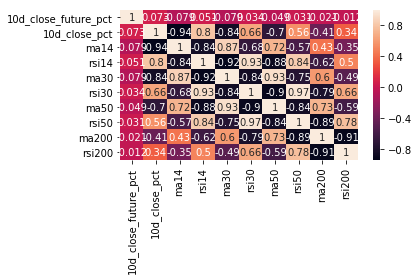

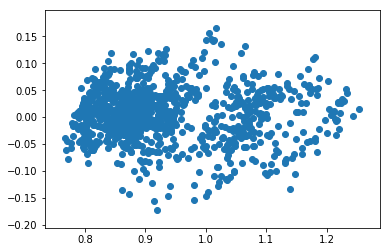

In [16]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(df['ma200'], df['10d_close_future_pct'])
plt.show()

**Create train and test features**

Before we fit our linear model, we want to add a constant to our features, so we have an intercept for our linear model.

We also want to create train and test features. This is so we can fit our model to the train dataset, and evaluate performance on the test dataset. We always want to check performance on data the model has not seen to make sure we're not overfitting, which is memorizing patterns in the training data too exactly.

With a time series like this, we typically want to use the oldest data as our training set, and the newest data as our test set. This is so we can evaluate the performance of the model on the most recent data, which will more realistically simulate predictions on data we haven't seen yet.

In [0]:
import statsmodels.api as sm

In [18]:
# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * targets.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(1048, 10) (890, 10) (158, 10)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**Fit a linear model**
We'll now fit a linear model, because they are simple and easy to understand. Once we've fit our model, we can see which predictor variables appear to be meaningfully linearly correlated with the target, as well as their magnitude of effect on the target. Our judgment of whether or not predictors are significant is based on the p-values of coefficients. This is using a t-test to statistically test if the coefficient significantly differs from 0. The p-value is the percent chance that the coefficient for a feature does not differ from zero. Typically, we take a p-value of less than 0.05 to mean the coefficient is significantly different from 0.

In [20]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                             OLS Regression Results                             
Dep. Variable:     10d_close_future_pct   R-squared:                       0.085
Model:                              OLS   Adj. R-squared:                  0.075
Method:                   Least Squares   F-statistic:                     9.039
Date:                  Sun, 08 Sep 2019   Prob (F-statistic):           3.82e-13
Time:                          14:15:06   Log-Likelihood:                 1495.2
No. Observations:                   890   AIC:                            -2970.
Df Residuals:                       880   BIC:                            -2922.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1130  

Now we can evaluate the results from our predictions.

**Evaluate our results**
Once we have our linear fit and predictions, we want to see how good the predictions are so we can decide if our model is any good or not. Ideally, we want to back-test any type of trading strategy. However, this is a complex and typically time-consuming experience.

A quicker way to understand the performance of our model is looking at regression evaluation metrics like R2, and plotting the predictions versus the actual values of the targets. Perfect predictions would form a straight, diagonal line in such a plot, making it easy for us to eyeball how our predictions are doing in different regions of price changes. We can use matplotlib's .scatter() function to create scatter plots of the predictions and actual values.

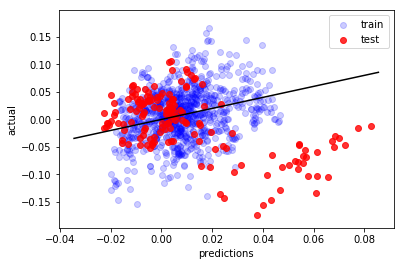

In [21]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.8, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

We can see our predictions are ok, but not very good yet. We need non-linearity! Coming right up...


---



# 2. Machine learning tree methods

Learn how to use tree-based machine learning models to predict future values of a stock's price, as well as how to use forest-based machine learning methods for regression and feature selection.

**Feature engineering from volume**

We're going to use non-linear models to make more accurate predictions. With linear models, features must be linearly correlated to the target. Other machine learning models can combine features in non-linear ways. For example, what if the price goes up when the moving average of price is going up, and the moving average of volume is going down? The only way to capture those interactions is to either multiply the features, or to use a machine learning algorithm that can handle non-linearity (e.g. random forests).

To incorporate more information that may interact with other features, we can add in weakly-correlated features

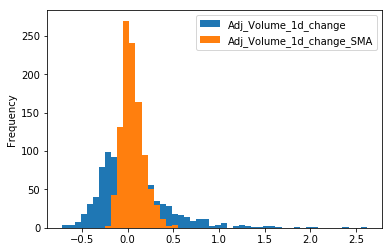

In [22]:
# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
df['Adj_Volume_1d_change'] = df['Volume'].pct_change(1)
df['Adj_Volume_1d_change_SMA'] = talib.SMA(df['Adj_Volume_1d_change'].values,
                        timeperiod=5)

# Plot histogram of volume % change data
df[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

We can see the moving average of volume changes has a much smaller range than the raw data.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048 entries, 2014-10-17 to 2018-12-14
Data columns (total 19 columns):
High                        1048 non-null float64
Low                         1048 non-null float64
Open                        1048 non-null float64
Close                       1048 non-null float64
Volume                      1048 non-null float64
Adj Close                   1048 non-null float64
10d_future_close            1048 non-null float64
10d_close_future_pct        1048 non-null float64
10d_close_pct               1048 non-null float64
ma14                        1048 non-null float64
rsi14                       1048 non-null float64
ma30                        1048 non-null float64
rsi30                       1048 non-null float64
ma50                        1048 non-null float64
rsi50                       1048 non-null float64
ma200                       1048 non-null float64
rsi200                      1048 non-null float64
Adj_Volume_1d_change     

**Create day-of-week features**

We can engineer datetime features to add even more information for our non-linear models. Most financial data has datetimes, which have lots of information in them -- year, month, day, and sometimes hour, minute, and second. But we can also get the day of the week, and things like the quarter of the year, or the elapsed time since some event (e.g. earnings reports).

We are only going to get the day of the week here, since our dataset doesn't go back very far in time. The dayofweek property from the pandas datetime index will help us get the day of the week. Then we will dummy dayofweek with pandas' get_dummies(). This creates columns for each day of the week with binary values (0 or 1). We drop the first column because it can be inferred from the others.

In [24]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(df.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = df.index

# Join the dataframe with the days of week dataframe
df = pd.concat([df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
df.dropna(inplace=True)  # drop missing values in-place
print(df.head())

                  High         Low        Open  ...  weekday_2  weekday_3  weekday_4
Date                                            ...                                 
2014-10-24  105.489998  104.529999  105.180000  ...          0          0          1
2014-10-27  105.480003  104.699997  104.849998  ...          0          0          0
2014-10-28  106.739998  105.349998  105.400002  ...          0          0          0
2014-10-29  107.370003  106.360001  106.650002  ...          1          0          0
2014-10-30  107.349998  105.900002  106.959999  ...          0          1          0

[5 rows x 23 columns]


Good work engineering new features! Let's see how they correlate to the target.

**Examine correlations of the new features**

Now that we have our volume and datetime features, we want to check the correlations between our new features (stored in the new_features list) and the target (5d_close_future_pct) to see how strongly they are related. Recall pandas has the built-in .corr() method for DataFrames, and seaborn has a nice heatmap() function to show the correlations.

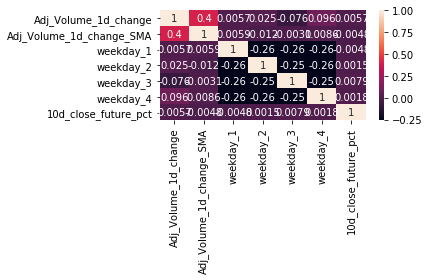

In [25]:
# Add the weekday labels to the new_features list
new_features.extend(['weekday_'+str(i) for i in range(1, 5)])

# Plot the correlations between the new features and the targets
sns.heatmap(df[new_features + ['10d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

In [26]:
new_features

['Adj_Volume_1d_change',
 'Adj_Volume_1d_change_SMA',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4']

Even though the correlations are weak, they may improve our predictions via interactions with other features.

# **Decision Tree**

**Fit a decision tree**

Random forests are a go-to model for predictions; they work well out of the box. But we'll first learn the building block of random forests -- decision trees.

Decision trees split the data into groups based on the features. Decision trees start with a root node, and split the data down until we reach leaf nodes.

We can use sklearn to fit a decision tree with DecisionTreeRegressor and .fit(features, targets).

Without limiting the tree's depth (or height), it will keep splitting the data until each leaf has 1 sample in it, which is the epitome of overfitting. 

In [27]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.9999982399203161
-1.0884966410047596


A perfect fit! ...on the training data.

**Try different max depths**

We always want to optimize our machine learning models to make the best predictions possible. We can do this by tuning hyperparameters, which are settings for our models. We will see in more detail how these are useful in future chapters, but for now think of them as knobs we can turn to tune our predictions to be as good as possible.

For regular decision trees, probably the most important hyperparameter is max_depth. This limits the number of splits in a decision tree. Let's find the best value of max_depth based on the R2 score of our model on the test set, which we can obtain using the score() method of our decision tree models.

In [28]:
# Loop through a few different max depths and check the performance
for d in [3,5,10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.0863314901211415
-0.22096307894083633 

max_depth= 5
0.2864029417990164
-0.5989230959562049 

max_depth= 10
0.8177790399439981
-0.9419170285887495 



Remember what value of max_depth got the highest test score.

**Check our results**

Once we have an optimized model, we want to check how it is performing in more detail. We already saw the R2 score, but it can be helpful to see the predictions plotted vs actual values. We can use the .predict() method of our decision tree model to get predictions on the train and test sets.

Ideally, we want to see diagonal lines from the lower left to the upper right. However, due to the simplicity of decisions trees, our model is not going to do well on the test set. But it will do well on the train set.

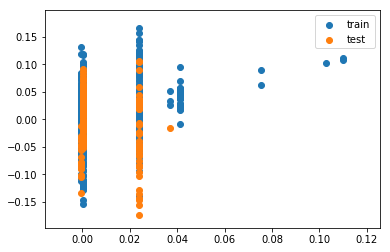

In [29]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

The predictions group into lines because our depth is limited.

# **Random Forest**

**Fit a random forest**

Data scientists often use random forest models. They perform well out of the box, and have lots of settings to optimize performance. Random forests can be used for classification or regression; we'll use it for regression to predict the future price change of LNG.

We'll create and fit the random forest model similarly to the decision trees using the .fit(features, targets) method. With sklearn's RandomForestRegressor, there's a built-in .score() method we can use to evaluate performance. This takes arguments (features, targets), and returns the R2 score (the coefficient of determination).

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9357211487627325
-0.505554418039525


Now let's tune the hyperparameters for better performance.

**Tune random forest hyperparameters**

As with all models, we want to optimize performance by tuning hyperparameters. We have many hyperparameters for random forests, but the most important is often the number of features we sample at each split, or max_features in RandomForestRegressor from the sklearn library. For models like random forests that have randomness built-in, we also want to set the random_state. This is set for our results to be reproducible.

Usually, we can use sklearn's GridSearchCV() method to search hyperparameters, but with a financial time series, we don't want to do cross-validation due to data mixing. We want to fit our models on the oldest data and evaluate on the newest data. So we'll use sklearn's ParameterGrid to create combinations of hyperparameters to search.

In [31]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.16329474370551078 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


Our test score (R^2) isn't great.

In [32]:
from pprint import pprint
pprint(list(ParameterGrid(grid)))

[{'max_depth': 3, 'max_features': 4, 'n_estimators': 200, 'random_state': 42},
 {'max_depth': 3, 'max_features': 8, 'n_estimators': 200, 'random_state': 42}]


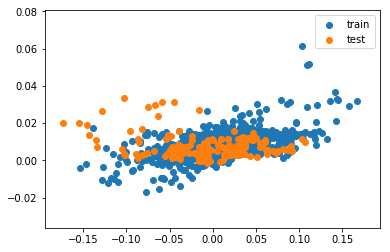

In [33]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

We can see our train predictions are good, but test predictions (generalization) are not great.

 **Random forest feature importances**
 
One useful aspect of tree-based methods is the ability to extract feature importances. This is a quantitative way to measure how much each feature contributes to our predictions. It can help us focus on our best features, possibly enhancing or tuning them, and can also help us get rid of useless features that may be cluttering up our model.

Tree models in sklearn have a .feature_importances_ property that's accessible after fitting the model. This stores the feature importance scores. We need to get the indices of the sorted feature importances using np.argsort() in order to make a nice-looking bar plot of feature importances (sorted from greatest to least importance).

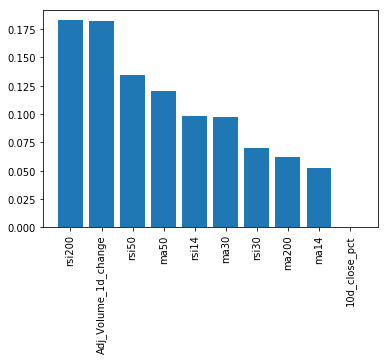

In [34]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

**A gradient boosting model**

Now we'll fit a gradient boosting (GB) model. It's been said a linear model is like a Toyota Camry, and GB is like a Black Hawk helicopter. GB has potential to outperform random forests, but doesn't always do so. This is called the no free lunch theorem, meaning we should always try lots of different models for each problem.

GB is similar to random forest models, but the difference is that trees are built successively. With each iteration, the next tree fits the residual errors from the previous tree in order to improve the fit.

For now we won't search our hyperparameters -- they've been searched for you.

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.23941415191227963
-0.15731320391624504


 In this case the gradient boosting model isn't that much better than a random forest, but you know what they say -- no free lunch!

**Gradient boosting feature importances**

As with random forests, we can extract feature importances from gradient boosting models to understand which features are the best predictors. Sometimes it's nice to try different tree-based models and look at the feature importances from all of them. This can help average out any peculiarities that may arise from one particular model.

The feature importances are stored as a numpy array in the .feature_importances_ property of the gradient boosting model. We'll need to get the sorted indices of the feature importances, using np.argsort(), in order to make a nice plot. We want the features from largest to smallest, so we will use Python's indexing to reverse the sorted importances like feat_importances[::-1].

In [0]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-7]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

In [0]:
feature_names[:-4]



---



# 3. Neural networks and KNN

We will see how to normalize and scale data for use in KNN and neural network methods. Then we will learn how to use KNN and neural network regression to predict the future values of a stock's price (or any other regression problem).

**Standardizing data**

Some models, like K-nearest neighbors (KNN) & neural networks, work better with scaled data -- so we'll standardize our data.

We'll also remove unimportant variables (day of week), according to feature importances, by indexing the features DataFrames with .iloc[]. KNN uses distances to find similar points for predictions, so big features outweigh small ones. Scaling data fixes that.

sklearn's scale() will standardize data, which sets the mean to 0 and standard deviation to 1. Ideally we'd want to use StandardScaler with fit_transform() on the training data, and fit() on the test data, but we are limited to 15 lines of code here.

Once we've scaled the data, we'll check that it worked by plotting histograms of the data.

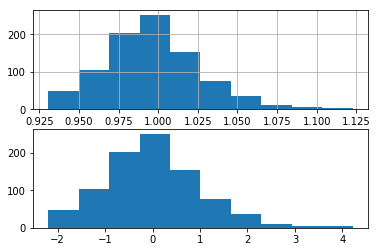

In [37]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

**Optimize n_neighbors**

Now that we have scaled data, we can try using a KNN model. To maximize performance, we should tune our model's hyperparameters. For the k-nearest neighbors algorithm, we only have one hyperparameter: n, the number of neighbors. We set this hyperparameter when we create the model with KNeighborsRegressor. The argument for the number of neighbors is n_neighbors.

We want to try a range of values that passes through the setting with the best performance. Usually we will start with 2 neighbors, and increase until our scoring metric starts to decrease. We'll use the R2 value from the .score() method on the test set (scaled_test_features and test_targets) to optimize n here. We'll use the test set scores to determine the best n.

In [38]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.683873867087093
-0.316511024415836

n_neighbors = 3
train, test scores
0.5269179339474739
-0.2284833282493588

n_neighbors = 4
train, test scores
0.4324059692615415
-0.19178369746896617

n_neighbors = 5
train, test scores
0.3693877283655388
-0.17810781775933626

n_neighbors = 6
train, test scores
0.33515692652591134
-0.11107975975892703

n_neighbors = 7
train, test scores
0.3075789808606424
-0.09147212776013203

n_neighbors = 8
train, test scores
0.2719421586470634
-0.12337318411976382

n_neighbors = 9
train, test scores
0.24250440705292953
-0.14241151236648641

n_neighbors = 10
train, test scores
0.232684427058099
-0.13728510902156144

n_neighbors = 11
train, test scores
0.22797027052258478
-0.11489328907440699

n_neighbors = 12
train, test scores
0.21331491868877628
-0.12516969052957405



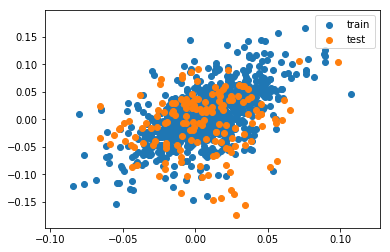

In [39]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

# **Neural Networks**


**Build and fit a simple neural net**

The next model we will learn how to use is a neural network. Neural nets can capture complex interactions between variables, but are difficult to set up and understand. Recently, they have been beating human experts in many fields, including image recognition and gaming (check out AlphaGo) -- so they have great potential to perform well.

To build our nets we'll use the keras library. This is a high-level API that allows us to quickly make neural nets, yet still exercise a lot of control over the design. The first thing we'll do is create almost the simplest net possible -- a 3-layer net that takes our inputs and predicts a single value. Much like the sklearn models, keras models have a .fit() method that takes arguments of (features, targets).

In [40]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Using TensorFlow backend.








Epoch 1/25
890/890 [==============================] - 1s 723us/step - loss: 0.0100
Epoch 2/25
890/890 [==============================] - 0s 35us/step - loss: 0.0034
Epoch 3/25
890/890 [==============================] - 0s 42us/step - loss: 0.0027
Epoch 4/25
890/890 [==============================] - 0s 40us/step - loss: 0.0026
Epoch 5/25
890/890 [==============================] - 0s 41us/step - loss: 0.0025
Epoch 6/25
890/890 [==============================] - 0s 38us/step - loss: 0.0024
Epoch 7/25
890/890 [==============================] - 0s 37us/step - loss: 0.0023
Epoch 8/25
890/890 [==============================] - 0s 40us/step - loss: 0.0022
Epoch 9/25
890/890 [==============================] - 0s 37us/step - loss: 0.0022
Epoch 10/25
890/890 [==============================] - 0s 35us/step - loss: 0.0020
Epoch 11/25
890/890 [==============================] - 0s 36us/step - loss: 0.0021
Epoch 12/25
890/890 [==============================] - 0s 42us/step - loss: 0.0021
Epoch 

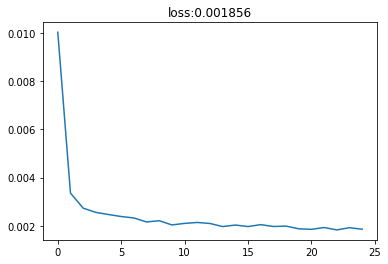

In [41]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Measure performance**

Now that we've fit our neural net, let's check performance to see how well our model is predicting new values. There's not a built-in .score() method like with sklearn models, so we'll use the r2_score() function from sklearn.metrics. This calculates the R2 score given arguments (y_true, y_predicted). We'll also plot our predictions versus actual values again. This will yield some interesting results soon (once we implement our own custom loss function).

0.17428713029288667
-0.19252164462840393


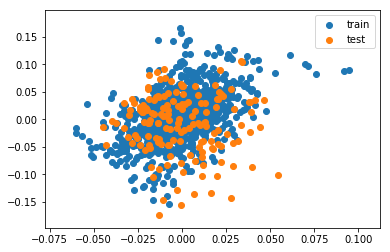

In [42]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

**Custom loss function**

Up to now, we've used the mean squared error as a loss function. This works fine, but with stock price prediction it can be useful to implement a custom loss function. A custom loss function can help improve our model's performance in specific ways we choose. For example, we're going to create a custom loss function with a large penalty for predicting price movements in the wrong direction. This will help our net learn to at least predict price movements in the correct direction.

To do this, we need to write a function that takes arguments of (y_true, y_predicted). We'll also use functionality from the backend keras (using tensorflow) to find cases where the true value and prediction don't match signs, then penalize those cases.

In [43]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x7f0c78cd5d08>


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
890/890 [==============================] - 0s 257us/step - loss: 1.6985
Epoch 2/25
890/890 [==============================] - 0s 37us/step - loss: 0.2936
Epoch 3/25
890/890 [==============================] - 0s 36us/step - loss: 0.1981
Epoch 4/25
890/890 [==============================] - 0s 40us/step - loss: 0.1597
Epoch 5/25
890/890 [==============================] - 0s 41us/step - loss: 0.1330
Epoch 6/25
890/890 [==============================] - 0s 37us/step - loss: 0.1167
Epoch 7/25
890/890 [==============================] - 0s 36us/step - loss: 0.1290
Epoch 8/25
890/890 [==============================] - 0s 41us/step - loss: 0.1284
Epoch 9/25
890/890 [==============================] - 0s 39us/step - loss: 0.1296
Epoch 10/25
890/890 [==============================] - 0s 37us/step - loss: 0.1092
Epoch 11/25
890/890 [==============================] - 0s 38us/step - loss: 0.1374
E

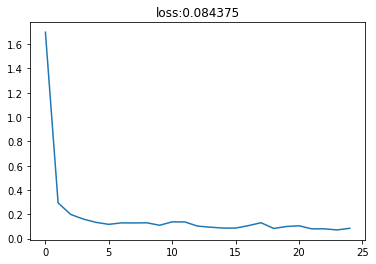

In [44]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Visualize the results**

We've fit our model with the custom loss function, and it's time to see how it is performing. We'll check the R2 values again with sklearn's r2_score() function, and we'll create a scatter plot of predictions versus actual values with plt.scatter(). This will yield some interesting results!

0.13300497833001046
-0.24167626075200244


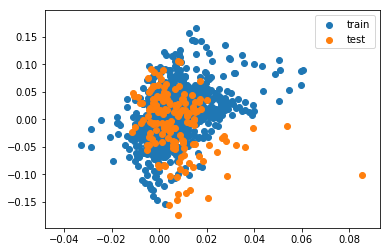

In [45]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

**Combatting overfitting with dropout**

A common problem with neural networks is they tend to overfit to training data. What this means is the scoring metric, like R2 or accuracy, is high for the training set, but low for testing and validation sets, and the model is fitting to noise in the training data.

We can work towards preventing overfitting by using dropout. This randomly drops some neurons during the training phase, which helps prevent the net from fitting noise in the training data. keras has a Dropout layer that we can use to accomplish this. We need to set the dropout rate, or fraction of connections dropped during training time. This is set as a decimal between 0 and 1 in the Dropout() layer.

We're going to go back to the mean squared error loss function for this model.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/25
890/890 [==============================] - 0s 305us/step - loss: 0.0164
Epoch 2/25
890/890 [==============================] - 0s 44us/step - loss: 0.0079
Epoch 3/25
890/890 [==============================] - 0s 41us/step - loss: 0.0055
Epoch 4/25
890/890 [==============================] - 0s 44us/step - loss: 0.0046
Epoch 5/25
890/890 [==============================] - 0s 43us/step - loss: 0.0041
Epoch 6/25
890/890 [==============================] - 0s 49us/step - loss: 0.0034
Epoch 7/25
890/890 [==============================] - 0s 42us/step - loss: 0.0031
Epoch 8/25
890/890 [==============================] - 0s 42us/step - loss: 0.0029
Epoch 9/25
890/890 [==============================] - 0s 41us/step - loss: 0.0030
Epoch 10/25
890/890 [==============================] - 0s 42us/step - loss: 0.0028
Epoch 11/25
890/890 [==============================] - 0s 42us/

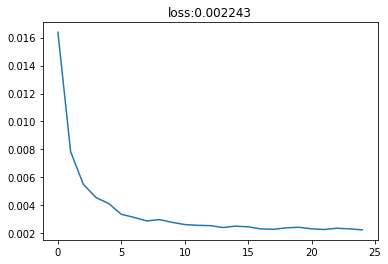

In [46]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

**Ensembling models**

One approach to improve predictions from machine learning models is ensembling. A basic approach is to average the predictions from multiple models. A more complex approach is to feed predictions of models into another model, which makes final predictions. Both approaches usually improve our overall performance (as long as our individual models are good). If you remember, random forests are also using ensembling of many decision trees.

To ensemble our neural net predictions, we'll make predictions with the 3 models we just created -- the basic model, the model with the custom loss function, and the model with dropout. Then we'll combine the predictions with numpy's .hstack() function, and average them across rows with np.mean(predictions, axis=1).

In [47]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[ 0.02994848  0.02539031  0.02909584  0.0068803  -0.0020048 ]


**See how the ensemble performed**

Let's check performance of our ensembled model to see how it's doing. We should see roughly an average of the R2 scores, as well as a scatter plot that is a mix of our previous models' predictions. The bow-tie shape from the custom loss function model should still be a bit visible, but the edges near x=0 should be softer.

0.17832378956974204
-0.24214592991949058


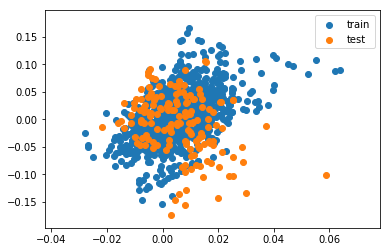

In [48]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')

plt.legend(); plt.show()

Our R^2 values are around the average of the 3 models we ensembled. Notice the plot also looks like the bow-tie shape has been softened a bit.


---



# 4. Machine learning with modern portfolio theory

In this section , you'll learn how to use modern portfolio theory (MPT) and the Sharpe ratio to plot and find optimal stock portfolios. You'll also use machine learning to predict the best portfolios. Finally, you'll evaluate performance of the ML-predicted portfolios.

**Get stock DataFrames and calculate returns**

Our first step towards calculating modern portfolio theory (MPT) portfolios is to get daily and monthly returns. Eventually we're going to get the best portfolios of each month based on the Sharpe ratio. The easiest way to do this is to put all our stock prices into one DataFrame, then to resample them to the daily and monthly time frames. We need daily price changes to calculate volatility, which we will use as our measure of risk.

In [0]:
full_df = web.DataReader(['LNG', 'SPY', 'SMLV'],'yahoo',start='1993-01-29',end='2019-09-01')['Adj Close']

#full_df = web.DataReader(['LNG', 'SPY', 'SMLV'],'yahoo',start=start,end=end)['Adj Close']

#full_df = pd.concat([lng['LNG'], spy['SPY'], smlv['SMLV']], axis=1, ignore_index=False).dropna()

In [90]:
full_df.head()

Symbols,LNG,SMLV,SPY
Date,,,
1993-01-29,NaN,NaN,26.706757
1993-02-01,NaN,NaN,26.896694
1993-02-02,NaN,NaN,26.953669
1993-02-03,NaN,NaN,27.238594
1993-02-04,NaN,NaN,27.352570


In [91]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6696 entries, 1993-01-29 to 2019-08-30
Data columns (total 3 columns):
LNG     6399 non-null float64
SMLV    1644 non-null float64
SPY     6696 non-null float64
dtypes: float64(3)
memory usage: 209.2 KB


In [92]:
full_df.describe()

Symbols,LNG,SMLV,SPY
count,6399.000000,1644.000000,6696.000000
mean,21.614142,72.033842,111.715838
std,22.302389,14.447508,65.736666
min,0.400000,46.307892,26.383823
25%,3.000000,59.897243,71.553551
50%,10.000000,66.764145,93.927364
75%,37.669998,86.261051,128.409050
max,84.459999,96.758392,302.010010


In [93]:
# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

Symbols          LNG      SMLV       SPY
Date                                    
2019-04-01  0.061875 -0.007942  0.023782
2019-05-01 -0.051648  0.011040  0.020922
2019-06-03  0.004500 -0.039396 -0.059079
2019-07-01  0.083102  0.049774  0.082048
2019-08-01 -0.090844  0.007598 -0.002773


In [94]:
returns_monthly.head()

Symbols,LNG,SMLV,SPY
Date,,,
2013-03-01,-0.019008,0.000503,0.005752
2013-04-01,0.320416,0.037556,0.030465
2013-05-01,-0.001790,0.004701,0.014290
2013-06-03,0.048404,0.020168,0.038350
2013-07-01,-0.014022,-0.003296,-0.012998


**Calculate covariances for volatility**

In MPT, we quantify risk via volatility. The math for calculating portfolio volatility is complex, and it requires daily returns covariances. We'll now loop through each month in the returns_monthly DataFrame, and calculate the covariance of the daily returns.

With pandas datetime indices, we can access the month and year with df.index.month and df.index.year. We'll use this to create a mask for returns_daily that gives us the daily returns for the current month and year in the loop. We then use the mask to subset the DataFrame like this: df[mask]. This gets entries in the returns_daily DataFrame which are in the current month and year in each cycle of the loop. Finally, we'll use pandas' .cov() method to get the covariance of daily returns.

In [95]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

Symbols       LNG      SMLV       SPY
Symbols                              
LNG      0.000357  0.000197  0.000239
SMLV     0.000197  0.000144  0.000165
SPY      0.000239  0.000165  0.000211


**Calculate portfolios**

We'll now generate portfolios to find each month's best one. numpy's random.random() generates random numbers from a uniform distribution, then we normalize them so they sum to 1 using the /= operator. We use these weights to calculate returns and volatility. Returns are sums of weights times individual returns. Volatility is more complex, and involves the covariances of the different stocks.

Finally we'll store the values in dictionaries for later use, with months' dates as keys.

In this case, we will only generate 10 portfolios for each date so the code will run faster, but in a real-world use-case you'd want to use more like 1000 to 5000 randomly-generated portfolios for a few stocks.

In [96]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(10):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.42502081 0.01960635 0.55537284]


**Plot efficient frontier**

We can finally plot the results of our MPT portfolios, which shows the "efficient frontier". This is a plot of the volatility vs the returns. This can help us visualize our risk-return possibilities for portfolios. The upper left boundary of the points is the best we can do (highest return for a given risk), and that is the efficient frontier.

To create this plot, we will use the latest date in our covariances dictionary which we created a few exercises ago. This has dates as keys, so we'll get the sorted keys using sorted() and .keys(), then get the last entry with Python indexing ([-1]). Lastly we'll use matplotlib to scatter variance vs returns and see the efficient frontier for the latest date in the data.

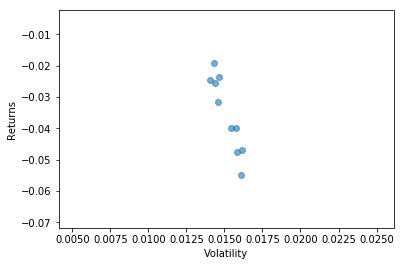

In [112]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.6)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

**Get best Sharpe ratios**

We need to find the "ideal" portfolios for each date so we can use them as targets for machine learning. We'll loop through each date in portfolio_returns, then loop through the portfolios we generated with portfolio_returns[date]. We'll then calculate the Sharpe ratio, which is the return divided by volatility (assuming a no-risk return of 0).

We use enumerate() to loop through the returns for the current date (portfolio_returns[date]) and keep track of the index with i. Then we use the current date and current index to get the volatility of each portfolio with portfolio_volatility[date][i]. Finally, we get the index of the best Sharpe ratio for each date using np.argmax(). We'll use this index to get the ideal portfolio weights soon.

In [98]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

-0.019335165131204354


**Calculate EWMAs**

We will now work towards creating some features to be able to predict our ideal portfolios. We will simply use the price movement as a feature for now. To do this we will create a daily exponentially-weighted moving average (EWMA), then resample that to the monthly timeframe. Finally, we'll shift the monthly moving average of price one month in the future, so we can use it as a feature for predicting future portfolios.

In [99]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

Symbols
LNG     0.003301
SMLV    0.001303
SPY     0.001764
Name: 2019-08-01 00:00:00, dtype: float64


**Make features and targets**

To use machine learning to pick the best portfolio, we need to generate features and targets. Our features were just created in the last exercise – the exponentially weighted moving averages of prices. Our targets will be the best portfolios we found from the highest Sharpe ratio.

We will use pandas' .iterrows() method to get the index, value pairs for the ewma_monthly DataFrame. We'll set the current value of ewma_monthly in the loop to be our features. Then we'll use the index of the best Sharpe ratio (from max_sharpe_idxs) to get the best portfolio_weights for each month and set that as a target.

In [100]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[0.47685211 0.02255415 0.50059374]
 [0.02427809 0.79830002 0.17742189]
 [0.49062247 0.30201596 0.20736157]
 [0.24452458 0.24296054 0.51251488]
 [0.21959344 0.26784704 0.51255951]]


**Plot efficient frontier with best Sharpe ratio**

Let's now plot the efficient frontier again, but add a marker for the portfolio with the best Sharpe index. Visualizing our data is always a good idea to better understand it.

Recall the efficient frontier is plotted in a scatter plot of portfolio volatility on the x-axis, and portfolio returns on the y-axis. We'll get the latest date we have in our data from covariances.keys(), although any of the portfolio_returns, etc, dictionaries could be used as well to get the date. Then we get volatilities and returns for the latest date we have from our portfolio_volatility and portfolio_returns. Finally we get the index of the portfolio with the best Sharpe index from max_sharpe_idxs[date], and plot everything with plt.scatter().

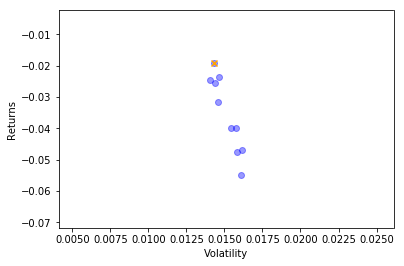

In [114]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.4, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

**Make predictions with a random forest**

In order to fit a machine learning model to predict ideal portfolios, we need to create train and test sets for evaluating performance. We will do this as we did in previous chapters, where we take our features and targets arrays, and split them based on a train_size we set. Often the train size may be around 70-90% of our data.

We then fit our model (a random forest in this case) to the training data, and evaluate the R2 scores on train and test using .score() from our model. In this case, the hyperparameters have been set for you, but usually you'd want to do a search with ParameterGrid like we did in previous chapters.

In [108]:
from sklearn.ensemble import RandomForestRegressor
# Make train and test features
train_size = int(0.85 * features.shape[1])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.7385555555555592
-0.5712005909016334


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

**Get predictions and first evaluation**

Now that we have a trained random forest model (rfr), we want to use it to get predictions on the test set. We do this to evaluate our model's performance – at a basic level, is it doing as well or better than just buying the index, SPY?

We'll use the typical sklearn .predict(features) method, then multiply our monthly returns by our portfolio predictions. We sum these up with np.sum() since this will have 3 rows for each month. Then we plot both the monthly returns from our predictions, as well as SPY and compare the two.

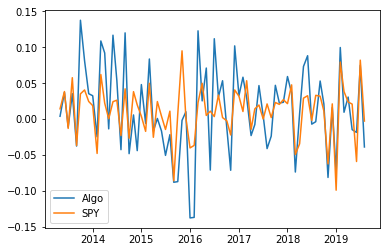

In [109]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='Algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.legend()
plt.show()

**Evaluate returns**

Let's now see how our portfolio selection would perform as compared with just investing in the SPY. We'll do this to see if our predictions are promising, despite the low R2 value.

We will set a starting value for our investment of $1000, then loop through the returns from our predictions as well as from SPY. We'll use the monthly returns from our portfolio selection and SPY and apply them to our starting cash balance. From this we will get a month-by-month picture of how our investment is doing, and we can see how our predictions did overall vs the SPY. Next, we can plot our portfolio from our predictions and compare it to SPY.

In [110]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 +r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 1.3778618391221444
SPY returns: 1.1386030981611188


**Plot returns**

Lastly, we'll plot the performance of our machine-learning-generated portfolio versus just holding the SPY. We can use this as an evaluation to see if our predictions are doing well or not.

Since we already have algo_cash and spy_cash created, all we need to do is provide them to plt.plot() to display. We'll also set the label for the datasets with legend in plt.plot().

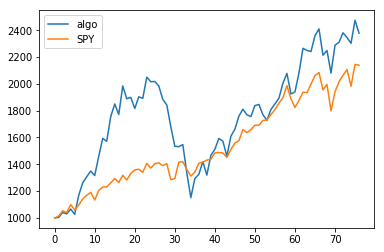

In [111]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()  # show the legend
plt.show()



---



# 5. Predicting Google Stock

In [115]:
google.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,559.434448,554.684692,558.288269,557.117126,3639100.0,557.117126
2014-01-03,559.024048,553.018005,558.058044,553.053040,3330000.0,553.053040
2014-01-06,559.989990,553.773804,557.062073,559.219238,3535000.0,559.219238
2014-01-07,570.415405,561.141113,563.063049,570.000000,5100000.0,570.000000
2014-01-08,574.234253,567.212219,573.573547,571.186157,4480500.0,571.186157


In [0]:
close = google['Adj Close']
moving_avg = close.rolling(window=100).mean()

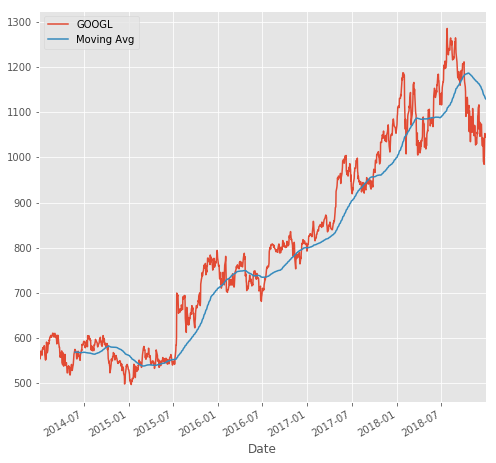

In [117]:
%matplotlib inline
from matplotlib import style
import matplotlib as pl

pl.rc('figure', figsize=(8,8))
#pl.__version__c

style.use('ggplot')

close.plot(label='GOOGL')
moving_avg.plot(label='Moving Avg')
plt.legend()

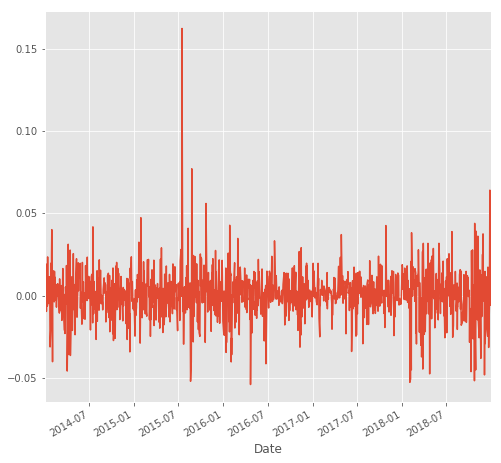

In [118]:
retrn = close / close.shift(1) - 1
retrn.plot(label='return')

In [0]:
#dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
#dfcomp.head()

In [120]:
#Feature Engineering
dfreg = google.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (google['High'] - google['Low']) / google['Close'] * 100.0
dfreg['PCT_change'] = (google['Close'] - google['Open']) / google['Open'] * 100.0
dfreg.head()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2014-01-02,557.117126,3639100.0,0.852560,-0.209774
2014-01-03,553.053040,3330000.0,1.085979,-0.896861
2014-01-06,559.219238,3535000.0,1.111583,0.387240
2014-01-07,570.000000,5100000.0,1.627069,1.232002
2014-01-08,571.186157,4480500.0,1.229377,-0.416231


In [121]:
import math
forecast_out = int(math.ceil(0.01 * len(dfreg)))
print(forecast_out)
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg.head()


13


,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2014-01-02,557.117126,3639100.0,0.852560,-0.209774
2014-01-03,553.053040,3330000.0,1.085979,-0.896861
2014-01-06,559.219238,3535000.0,1.111583,0.387240
2014-01-07,570.000000,5100000.0,1.627069,1.232002
2014-01-08,571.186157,4480500.0,1.229377,-0.416231


In [122]:
import math
import numpy as np
from sklearn import preprocessing

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

print(dfreg.shape)
# We want to separate 1 percent of the data to forecast the results
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
dfreg['label'] = dfreg['Adj Close'].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

(1258, 4)
Dimension of X (1245, 4)
Dimension of y (1245,)


In [0]:
# Necessary imports
import math
import numpy as np
from sklearn.model_selection import train_test_split

# Model generation
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [0]:
# Separation of training and testing of model by cross validation train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [125]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [126]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [127]:
print('Reg1 Score: ' + str(clfreg.score(X_test, y_test)))
print('Reg2 Score: ' + str(clfpoly2.score(X_test,y_test)))
print('Reg3 Score: ' + str(clfpoly3.score(X_test,y_test)))
print('KNN Score: ' + str(clfknn.score(X_test, y_test)))

Reg1 Score: 0.9717811668984518
Reg2 Score: 0.9716889421076071
Reg3 Score: 0.9703560761007074
KNN Score: 0.9293421094416958


In [128]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set,  forecast_out)

[1077.03409499 1078.50307909 1055.59989123 1036.69366482 1045.88012721
 1046.64709994 1029.55424406  999.50387298  992.89781407 1052.06769723
 1057.50932189 1051.6045255  1052.52040283] 13


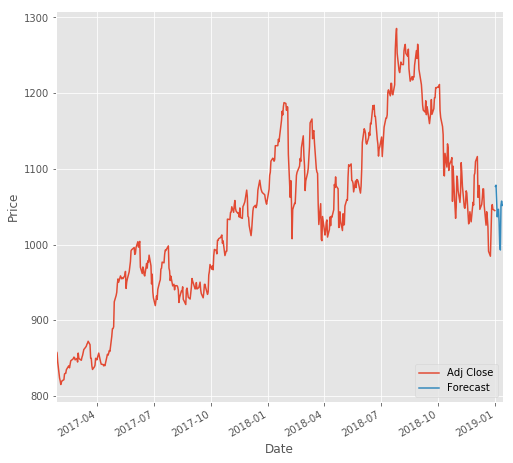

In [129]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()



---







![alt text](http://www.foxbyrd.com/wp-content/uploads/2018/02/file-4.jpg)








---

